In [1]:
import cv2
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import imageio
from skimage import img_as_float32
from natsort import natsorted

path_pairs = list(zip(
    natsorted(glob('../puzzle_corners_1024x768/images-1024x768/*.png')),
    natsorted(glob('../puzzle_corners_1024x768/masks-1024x768/*.png')),
))

imgs = np.array([img_as_float32(imageio.imread(ipath)) for ipath, _ in path_pairs])
msks = np.array([img_as_float32(imageio.imread(mpath)) for _, mpath in path_pairs])

# imgs_flat = imgs.reshape(-1,3) #might need to be 3 channels
# msks_flat = msks.reshape(-1)


In [2]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_test, msks_train, msks_test = train_test_split(
    imgs, msks, test_size=0.14, random_state=42)

In [3]:
imgs_train_flat =  imgs_train.reshape(-1,3)
msks_train_flat =  msks_train.reshape(-1)
imgs_test_flat = imgs_test.reshape(-1,3)
msks_test_flat =  msks_test.reshape(-1)

In [4]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=6)
# kf.get_n_splits(imgs_train)

In [5]:
from scipy.stats import multivariate_normal

In [6]:
multivariate_normal.pdf(10, mean=2.5, cov=0.5)

2.1006826890574786e-25

In [7]:
#imgs_train= imgs_train[:100]

In [8]:
imgs_train.shape

(41, 768, 1024, 3)

In [9]:
msks_train.shape

(41, 768, 1024)

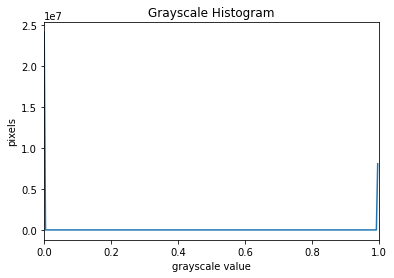

In [10]:
histogram, bin_edges = np.histogram(msks_train, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixels")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [11]:
class GMM:
    def __init__(self, K, num_features):
        self.K = K
        self.lambd = np.ones(K)/K
        
        self.num_features = num_features
        self.mean = np.random.random((K, num_features))
        
        self.cov = np.random.random((K,num_features,num_features))

        self.prevent_singular = np.zeros((K,num_features,num_features))
        for k in range(K):
            self.prevent_singular[k] = 1e-6*np.eye(num_features)
            self.cov[k] *= self.cov[k].T
            self.cov[k] += 1e+3*np.eye(num_features)
    
    def expectation(self, X):
        #make it self.R
        R = []
        R_denominator = 0
        for k in range(self.K):
            #r_k_numerator = self.lambd[k]*multivariate_normal.pdf(X, mean=self.mean[k], cov=self.cov[k])
            r_k_numerator = self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
            R_denominator += r_k_numerator
            R.append(r_k_numerator)
        
        R = np.array(R).T    
        l =  np.sum(np.log(np.sum(R, axis = 1)))
        R = R/(R.sum(axis = 1, keepdims = 1) + 1e-6)
        
        print(R.shape)
        
        return R, l
    
    
    def maximisation(self, X, R):
        
        sum_r_ik = np.sum(R, axis = 0)
        self.lambd = sum_r_ik/np.sum(R)
        
        self.mean = R.T @ X / sum_r_ik.reshape(-1,1) #lp
        
        for k in range(self.K):
            self.cov[k] = (R[:,k]*(X - self.mean[0]).T @ (X - self.mean[0])) / sum_r_ik[k]
            
            #########################################################
            self.cov = np.nan_to_num(self.cov) + self.prevent_singular
            ##--------------__#################-check

    def fit(self, X):
        for i in range(50):
            R , l1 = self.expectation(X)
            self.maximisation(X,R)
            print(l1)
    
    def predict(self, X):
        summ=0 
        for k in range(self.K):
            summ += self.lambd[k]*multivariate_normal(mean = self.mean[k], cov=self.cov[k]).pdf(X)
        return summ
        

In [12]:
imgs_train.shape

(41, 768, 1024, 3)

In [13]:
gmm_back = GMM(4, 3)
gmm_back.fit(imgs_train_flat[msks_train_flat<0.5])

(24160180, 4)
-316956312.2747051
(24160180, 4)
150683774.68029645
(24160180, 4)
150717474.12151903
(24160180, 4)
150907211.42042854
(24160180, 4)
151558349.19094923
(24160180, 4)
151974972.67124793
(24160180, 4)
151582383.65457493
(24160180, 4)
151313297.5756455
(24160180, 4)
151271998.50897878
(24160180, 4)
151258139.03122506
(24160180, 4)
151209829.4573972
(24160180, 4)
151112528.88983083
(24160180, 4)
150996491.49446955
(24160180, 4)
150889534.68268096
(24160180, 4)
150799784.61030915
(24160180, 4)
150725239.11057407
(24160180, 4)
150662026.72006658
(24160180, 4)
150606928.80413428
(24160180, 4)
150557620.4570842
(24160180, 4)
150512474.30930778
(24160180, 4)
150470401.44876906
(24160180, 4)
150430715.22144216
(24160180, 4)
150393008.41423714
(24160180, 4)
150357051.35914698
(24160180, 4)
150322722.32037196
(24160180, 4)
150289958.1773447
(24160180, 4)
150258719.88066083
(24160180, 4)
150228969.72184092
(24160180, 4)
150200659.02101028
(24160180, 4)
150173725.5404585
(24160180, 4)
1

In [14]:
gmm_fore = GMM(4, 3)
gmm_fore.fit(imgs_train_flat[msks_train_flat>0.5])

(8083532, 4)
-106047247.99553731
(8083532, 4)
23474957.259679366
(8083532, 4)
23316669.55681572
(8083532, 4)
22826642.102296215
(8083532, 4)
23259523.395202752
(8083532, 4)
25002157.22104125
(8083532, 4)
25336330.17168769
(8083532, 4)
24032713.691473003
(8083532, 4)
23672682.443332188
(8083532, 4)
23216955.547080636
(8083532, 4)
22803683.37368864
(8083532, 4)
22438160.376702636
(8083532, 4)
22145870.169465646
(8083532, 4)
21958328.479430005
(8083532, 4)
21901504.238020394
(8083532, 4)
21967748.262799364
(8083532, 4)
22107292.223238185
(8083532, 4)
22266742.812650718
(8083532, 4)
22410196.424720988
(8083532, 4)
22509549.776942287
(8083532, 4)
22537875.729082197
(8083532, 4)
22481265.44647943
(8083532, 4)
22358853.113981288
(8083532, 4)
22215494.99671086
(8083532, 4)
22078744.32129839
(8083532, 4)
21943552.372473408
(8083532, 4)
21806111.41032441
(8083532, 4)
21674861.43905261
(8083532, 4)
21556529.91954057
(8083532, 4)
21454483.295095075
(8083532, 4)
21371235.54702476
(8083532, 4)
21310

In [16]:
fore = gmm_fore.predict(imgs_test_flat)
back = gmm_back.predict(imgs_test_flat)

In [17]:
y = (0.4 * fore) / ((0.4 * fore) + ((1 - 0.4) * back))

In [18]:
preds = (y>0.5).astype(np.float32)

In [19]:
msks_test_flat[msks_test_flat>0.5] = 1.
msks_test_flat[msks_test_flat<0.5] = 0
np.unique(msks_test_flat)

array([0., 1.], dtype=float32)

In [22]:
len(preds[preds == msks_test_flat])/len(preds)

0.9754853021530878

In [23]:
pred_ims = preds.reshape(msks_test.shape)

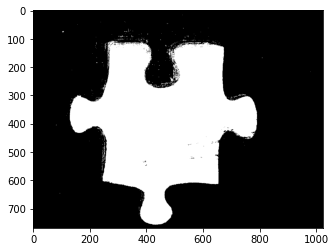

In [25]:
plt.imshow(pred_ims[0], cmap = 'gray')

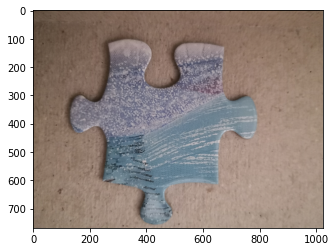

In [28]:
plt.imshow(imgs_test[0])